In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


If you are running this notebook in a binder instance, you need to install the ringdown package, so execute this cell:

In [ ]:
!pip install ringdown

In [3]:
import ringdown

# Data

## PSDs and ACFs

In [4]:
# simulate 2s of white Gaussian noise sampled at 8192 Hz

x = ringdown.Data(random.normal(0, 1, 16384),
                 ifo='H1', index=arange(16384)/8192)
x

0.000000    0.739686
0.000122   -1.558582
0.000244    0.681971
0.000366   -0.214481
0.000488    0.893993
              ...   
1.999390   -1.542292
1.999512    0.441358
1.999634    0.503663
1.999756    0.047151
1.999878    0.446778
Length: 16384, dtype: float64

In [5]:
# access some attributes
x.ifo, x.delta_t, x.duration, x.delta_f, x.fsamp

('H1', 0.0001220703125, 2.0, 0.5, 8192.0)

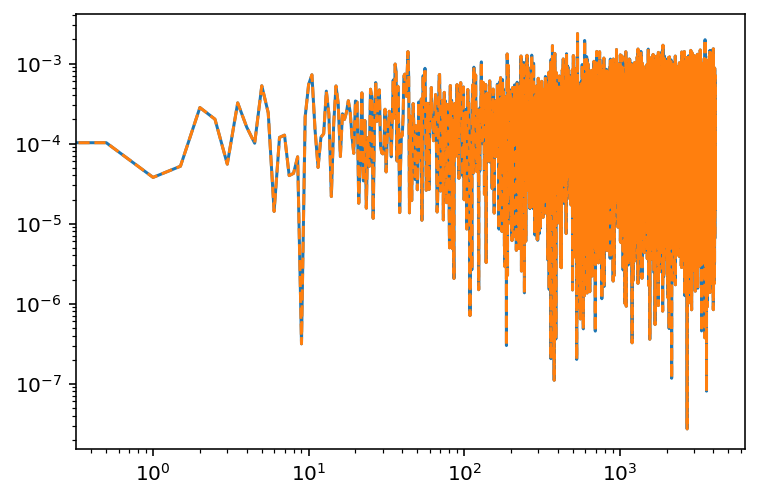

In [6]:
# get a PSD
p = x.get_psd(nperseg=len(x))

# this is the same as the Welch PSD
import scipy.signal as sig
freq, psd = sig.welch(x, fs=x.fsamp, nperseg=len(x))

loglog(p.freq, p)
loglog(freq, psd, ls='--')

In [7]:
# the PSD is a FrequencySeries with some attributes
p.delta_t, p.duration, p.delta_f, p.fsamp

(0.0001220703125, 1.0001220703125, 0.5, 8192.0)

In [8]:
# from the psd we can get an ACF
acf_fd = p.to_acf()
acf_fd

0.000000    1.002041
0.000122    0.000818
0.000244   -0.000799
0.000366   -0.015755
0.000488   -0.007557
              ...   
1.999390    0.003996
1.999512   -0.007557
1.999634   -0.015755
1.999756   -0.000799
1.999878    0.000818
Length: 16384, dtype: float64

In [9]:
# or we could have produced this directly from the original data
x.get_acf(method='fd')

/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 49152 is greater than input length  = 16384, using nperseg = 16384
  warnings.warn('nperseg = {0:d} is greater than input length '


0.000000    1.002041
0.000122    0.000818
0.000244   -0.000799
0.000366   -0.015755
0.000488   -0.007557
              ...   
1.999390    0.003996
1.999512   -0.007557
1.999634   -0.015755
1.999756   -0.000799
1.999878    0.000818
Length: 16384, dtype: float64

In [10]:
# the default method is through correlate
# (see documentation or code for all options)
acf_td = x.get_acf()
acf_td

0.000000    0.988870
0.000122   -0.000132
0.000244    0.000390
0.000366   -0.002569
0.000488   -0.003073
              ...   
1.999390    0.000008
1.999512    0.000148
1.999634   -0.000070
1.999756    0.000043
1.999878   -0.000023
Length: 16384, dtype: float64

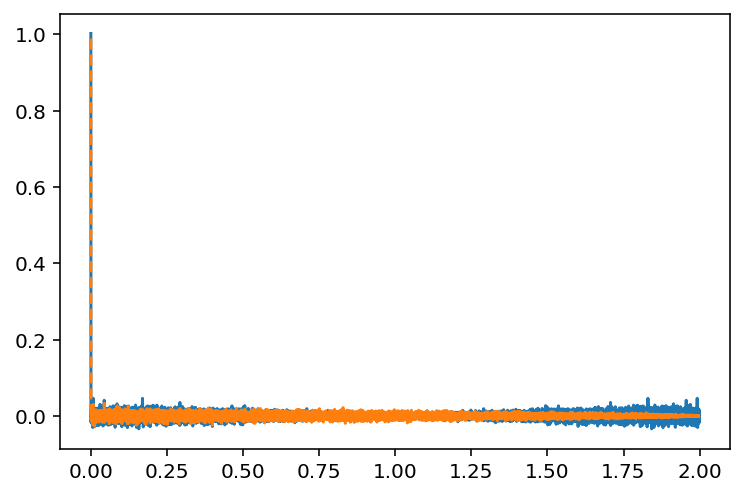

In [11]:
plot(acf_fd.time, acf_fd)
plot(acf_td.time, acf_td, ls='--')

In [ ]:
%time

# acfs objects know how to compute, and cache, the cholesky decomp 
# of their corresponding covariance matrix

acf_td.cholesky

In [13]:
%time
L = acf_td.cholesky

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


## Conditioning

In [12]:
# Data objects know how to return a conditioned copy of themselves

# highpass and downsample by 2, assume analysis time will be 1
x_cond = x.condition(flow=20, ds=2, t0=1)

# NOTE: condition takes a t0 argument specify a target time to be
# preserved after decimation by rolling

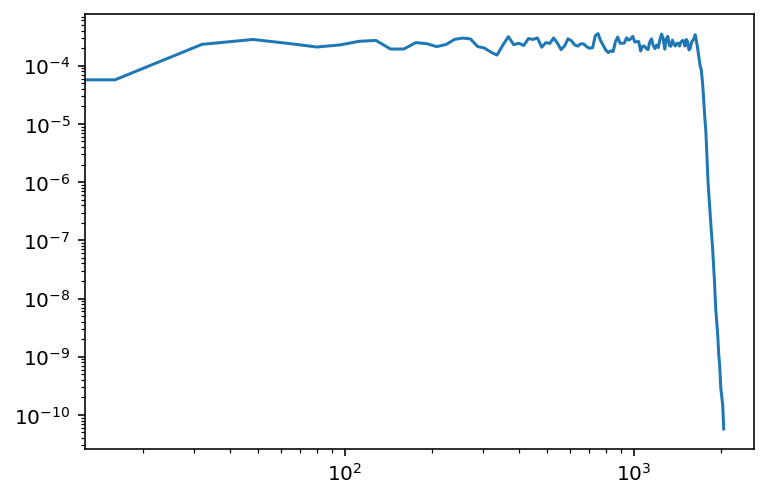

In [13]:
# look at the new psd (highpass won't be visible bc example seglen was too short)
p_cond = x_cond.get_psd()
loglog(p_cond.freq, p_cond)

In [14]:
# the conditioned data remember their identity
x_cond.ifo, x.ifo

('H1', 'H1')

# Fitting

## Frequency and damping

### setting prior and adding data

In [15]:
# let's create a fit object for a simple f-tau fit

# creating a Fit() object requires only the `model` key,
# others can be added later
# besides the `modes` kwarg, other arguments will be 
# passed to stan_data
f = ringdown.Fit(model='ftau', modes=2, A_max=0.5)

In [16]:
# we've created a model with 2 arbitrary modes
f.n_modes

2

In [17]:
# we've already specified we want the prior to allow ampltitudes
# up to A_max=0.5, we can check what other parameters we can set
f.valid_model_options

['A_scale', 'drift_scale', 'f_max', 'f_min', 'gamma_max', 'gamma_min']

In [18]:
# let's set the additional prior bounds we left out above
f.update_prior(A_scale=1E-21, f_min=100, f_max=500, gamma_min=100, gamma_max=500)

In [19]:
f.prior_settings

{'A_scale': 1e-21,
 'drift_scale': 0.0,
 'f_max': 500,
 'f_min': 100,
 'gamma_max': 500,
 'gamma_min': 100,
 'A_max': 0.5}

In [20]:
# let's add data to our Fit
f.add_data(x_cond, acf=acf_td)

In [21]:
f.data

{'H1': 0.500000    0.263570
 0.500244   -0.233825
 0.500488   -0.320144
 0.500732    0.164173
 0.500977    0.142091
               ...   
 1.498779    0.557353
 1.499023    0.301427
 1.499268   -0.314474
 1.499512    0.478424
 1.499756    0.427791
 Length: 4096, dtype: float64}

In [22]:
f.acfs

{'H1': 0.000000    0.988870
 0.000122   -0.000132
 0.000244    0.000390
 0.000366   -0.002569
 0.000488   -0.003073
               ...   
 1.999390    0.000008
 1.999512    0.000148
 1.999634   -0.000070
 1.999756    0.000043
 1.999878   -0.000023
 Length: 16384, dtype: float64}

In [23]:
# if we hadn't provided an ACF to add data, we could have asked
# Fit to compute it automatically for all added IFOs
f.compute_acfs()

# calling compute_acfs rewrote the ACF we had added

# NOTE: compute_acfs takes `shared` boolean argument that specifices if all
# IFOs are to share a single ACF, in which case the ACF is only computed
# once from the data of the first IFO (useful for simulated data)

# it also accepts an `ifos` argument, giving specific IFOs for which to 
# compute ACF, otherwise computes it for all

In [24]:
# now let's set an analysis target
# for this model this is just a start time (no sky loc required)
# and optionally an analysis duration

# let's pick t0 in the middle of the segment
t0 = x.time[0] + 0.5*x.duration

# and pass a duration (in same unit as time array)
# --- also accept a number of samples instead.
f.set_target(t0, duration=0.02)

In [25]:
f.target

Target(t0=1.0, ra=None, dec=None, psi=None)

In [26]:
f.t0, f.duration, f.n_analyze

(1.0, 0.02, 82)

In [27]:
# the data are not truncated at this point
# the following function returns the right slice 
f.analysis_data

{'H1': 1.000000   -0.284219
 1.000244   -0.065801
 1.000488    0.309009
 1.000732   -0.451872
 1.000977   -0.323978
               ...   
 1.018799    0.449870
 1.019043    0.638044
 1.019287   -0.960042
 1.019531   -0.192317
 1.019775    0.248700
 Length: 82, dtype: float64}

In [28]:
# we can get the index of the first analysis sample in the big segment
# corresponding to the analysis time (closest to t0)
f.start_indices

{'H1': 2048}

In [29]:
f.start_times

{'H1': 1.0}

In [30]:
f.data['H1'].time[f.start_indices['H1']]

1.0

### Compiling and fitting

Here are the various models we can use:

In [31]:
ringdown.MODELS

('ftau', 'mchi', 'mchi_aligned')

In [32]:
# to run the model all we need to do is call run()
# kwargs will be interpreted as stan run time settings (number of chains etc)
# the model will be compiled and cached (even between runs, based on a hash of the model code)
# and won't be compiled again until the cache is invalidated or the hash changes
# (and this would be true for other instance of Fit with the ftau model as well)
f.run()

Running ftau
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.6s
Building: 1.7s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.2s
Building: 8.3s
Building: 8.

In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/st

Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.3s
Building: 12.4s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/hmm_check.hpp:33:7: warning: unused variable 'n_transitions' [-Wunused-vari

Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.6s
Building: 14.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:96:39: warning: lambda capture 'a' is not used [

Building: 14.8s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:121:
/Users/wfarr/.venv/ringdown/lib/pyt

Building: 15.9s
Building: 16.0s
Building: 16.1s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:188:
/Users/wfarr/.venv/ringdown/lib/pyt

Building: 16.2s
Building: 16.3s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:123:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from

Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:157:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:40:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka 'long') and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (Eigen::Index k = 0; k < N; ++k) {
                           ~ ^ ~
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/si

Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:16:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/dae.hpp:5:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_integrator.hpp:5:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_service.hpp:93:28: warning: comparison of intege

Building: 21.5s
Building: 21.6s
Building: 21.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  size_t N = max_size(y, mu, sigma);
         ^
In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgz

Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 22.2s
Building: 22.3s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:308:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_lccdf.hpp:78:13: warning: u

Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.5s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:274:21: warning: comparison of integers of different signs: 'int' and 'std::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:528:21: warning: comparison of integers of different signs: 'int' and 'std::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < col_idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~

Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.1s
Building: 24.2s
Building: 24.3s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_subtraction.hpp:84:21: warning: lamb

Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.8s
Building: 24.9s
Building: 25.0s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.6s
Building: 25.7s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.2s
Building: 26.3s
Building: 26.4s
Building: 26.5s
Building: 26.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/grad_inc_beta.hpp:45:43: note: in instantiati

Building: 26.8s
Building: 26.9s
Building: 27.0s
Building: 27.1s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/trigamma.hpp:63:31: note: in instantiation o

Building: 27.2s
Building: 27.4s
Building: 27.5s
Building: 27.6s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.4s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 28.9s
Building: 29.0s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.5s
Building: 29.6s
Building: 29.8s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /User

Building: 29.9s
Building: 30.0s
Building: 30.1s
Building: 30.3s
Building: 30.4s
Building: 30.5s
Building: 30.6s
Building: 30.8s
Building: 30.9s
Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.3s
Building: 31.5s
Building: 31.6s
Building: 31.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:95:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:214:35: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
      reverse_pass_callback([ret, lp, arena_lb = var(lb)]() mutable {
                                  ^
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:209:21: note: in insta

Building: 31.8s
Building: 31.9s
Building: 32.0s
Building: 32.2s
Building: 32.3s
Building: 32.4s
Building: 32.5s
Building: 32.6s
Building: 32.8s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_subtraction.hpp:104:21: warning: lam

Building: 32.9s
Building: 33.0s
Building: 33.1s
Building: 33.2s
Building: 33.3s
Building: 33.4s
Building: 33.6s
Building: 33.7s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /User

Building: 33.8s
Building: 33.9s
Building: 34.0s
Building: 34.2s
Building: 34.3s
Building: 34.4s
Building: 34.5s
Building: 34.6s
Building: 34.7s
Building: 34.8s
Building: 34.9s
Building: 35.1s


In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp:2:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^
In file included from /Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.cpp

Building: 35.2s
Building: 35.3s
Building: 35.4s
Building: 35.5s
Building: 35.6s
Building: 35.7s
Building: 35.8s
Building: 36.0s
Building: 36.1s
Building: 36.2s
Building: 36.3s
Building: 36.5s
Building: 36.6s
Building: 36.7s
Building: 36.8s
Building: 36.9s
Building: 37.0s
Building: 37.1s
Building: 37.3s
Building: 37.4s
Building: 37.5s
Building: 37.6s
Building: 37.7s
Building: 37.8s
Building: 38.0s
Building: 38.1s
Building: 38.2s
Building: 38.3s
Building: 38.5s
Building: 38.6s
Building: 38.7s
Building: 38.8s
Building: 38.9s
Building: 39.0s
Building: 39.1s
Building: 39.2s
Building: 39.3s
Building: 39.4s
Building: 39.6s
Building: 39.7s
Building: 39.8s
Building: 39.9s
Building: 40.0s
Building: 40.1s
Building: 40.2s
Building: 40.3s
Building: 40.5s
Building: 40.6s
Building: 40.7s
Building: 40.8s
Building: 40.9s
Building: 41.0s
Building: 41.1s
Building: 41.2s
Building: 41.3s
Building: 41.4s
Building: 41.5s
Building: 41.7s
Building: 41.8s
Building: 41.9s
Building: 42.0s
Building: 42.1s
Building

65 warnings generated.


Building: 57.6s
Building: 57.7s
Building: 57.8s
Building: 57.9s
Building: 58.0s
Building: 58.1s


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-3.9/Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/wfarr/.venv/ringdown/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-3.9/Users/wfarr/Library/Caches/httpstan/4.7.0/models/6wgzmpcc/model_6wgzmpcc.o

In [33]:
# the result has been saved within the Fit object itself
f.result

Inference data with groups:
	> posterior
	> sample_stats

In [34]:
# we could've also done a prior-only run
f.run(prior=True)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_k4jqbamx/model_6wgzmpcc.stan', line 13, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_k4jqbamx/model_6wgzmpcc.stan', line 14, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_k4jqbamx/model_6wgzmpcc.stan', line 15, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    wil

Running ftau


Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (402/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  35% (2800/8000)
Sampling:  44% (3500/8000)
Sampling:  64% (5100/8000)
Sampling:  81% (6500/8000)
Sampling:  95% (7600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.00010

In [35]:
# the result is saved in prior
f.prior

Inference data with groups:
	> posterior
	> sample_stats

## Mass and spin

### setting prior and adding data

In [36]:
# the mass and spin fit works much in the same way

f2 = ringdown.Fit(model='mchi', A_scale=0.5)

In [37]:
# this time, we didn't add modes above, instead let's set 
# the modes to be a sequence of overtones (by default 22 mode, prograde)

# requesting 2 modes implies an N=1 fit (fundamental + overtone)
f2.set_tone_sequence(2)

In [38]:
# we can check that the modes have been added correctly
f2.modes

[ModeIndex(p=1, s=-2, l=2, m=2, n=0), ModeIndex(p=1, s=-2, l=2, m=2, n=1)]

In [39]:
# NOTE: the p index is +1 for prograde, and -1 for retrograde modes
# we could have equivalently passed `modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)]`
# when creating the Fit instance, or used its set_modes method with the same argument

In [40]:
# we've already specified we want the prior to allow amplitudes
# up to A_max=0.5, we can check what other parameters we can set
f2.valid_model_options

['A_scale',
 'perturb_f',
 'perturb_tau',
 'df_max',
 'dtau_max',
 'M_min',
 'M_max',
 'chi_min',
 'chi_max',
 'flat_A_ellip']

In [41]:
# let's set some additional prior bounds, for the others we'll use the default
f2.update_prior(M_min=50, M_max=100)

f2.prior_settings

{'A_scale': 0.5,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 50,
 'M_max': 100,
 'chi_min': 0,
 'chi_max': 0.99,
 'flat_A_ellip': 0}

In [42]:
# let's add data to our Fit
f2.add_data(x_cond)

# let's add a second IFO (cheating by just duplicating the same data)
y_cond = x_cond.copy()
y_cond.ifo = 'L1'

f2.add_data(y_cond)

In [43]:
f2.data

{'H1': 0.500000    0.263570
 0.500244   -0.233825
 0.500488   -0.320144
 0.500732    0.164173
 0.500977    0.142091
               ...   
 1.498779    0.557353
 1.499023    0.301427
 1.499268   -0.314474
 1.499512    0.478424
 1.499756    0.427791
 Length: 4096, dtype: float64,
 'L1': 0.500000    0.263570
 0.500244   -0.233825
 0.500488   -0.320144
 0.500732    0.164173
 0.500977    0.142091
               ...   
 1.498779    0.557353
 1.499023    0.301427
 1.499268   -0.314474
 1.499512    0.478424
 1.499756    0.427791
 Length: 4096, dtype: float64}

In [44]:
f2.ifos

['H1', 'L1']

In [45]:
# we haven't added any ACFs
f2.acfs

{}

In [46]:
# let's compute ACFs for all IFOs, but let's tell Fit
# that they all share a single ACF
f2.compute_acfs(shared=True)

f2.acfs

{'H1': 0.000000    0.414132
 0.000244    0.076534
 0.000488   -0.077128
 0.000732    0.044777
 0.000977   -0.039610
               ...   
 0.998779    0.000077
 0.999023    0.000017
 0.999268   -0.000081
 0.999512    0.000006
 0.999756    0.000028
 Length: 4096, dtype: float64,
 'L1': 0.000000    0.414132
 0.000244    0.076534
 0.000488   -0.077128
 0.000732    0.044777
 0.000977   -0.039610
               ...   
 0.998779    0.000077
 0.999023    0.000017
 0.999268   -0.000081
 0.999512    0.000006
 0.999756    0.000028
 Length: 4096, dtype: float64}

In [47]:
# now let's set an analysis target this time with a sky location

# let's pick t0 in the middle of the segment
# now the truncation time will be defined to be at geocenter
t0 = x.time[0] + 0.5*x.duration

# and pass a duration (in same unit as time array)
# --- also accept a number of samples instead.
f2.set_target(t0, 1.92, 0.8, 0, duration=0.02)

In [48]:
f2.target

Target(t0=1.0, ra=1.92, dec=0.8, psi=0)

In [49]:
f2.has_target

True

In [50]:
f2.t0, f.duration, f.n_analyze

(1.0, 0.02, 82)

In [51]:
# the target allows the fit to compute antenna patterns
f2.antenna_patterns

{'H1': [0.27314198380407506, -0.36414750450706745],
 'L1': [0.023415325210703053, 0.41321163714139464]}

In [52]:
# the data are not truncated at this point
# the following function returns the right slice 
# NOTE: the sky location is automatically taken into account
# so note the tart times are different
f2.analysis_data

{'H1': 0.994873    0.372472
 0.995117    0.718182
 0.995361    0.370477
 0.995605    0.601042
 0.995850    0.194705
               ...   
 1.013672   -0.091274
 1.013916   -0.285943
 1.014160   -0.577142
 1.014404    0.241410
 1.014648    0.836666
 Length: 82, dtype: float64,
 'L1': 0.993652    0.340330
 0.993896    0.317647
 0.994141    0.853941
 0.994385   -0.156692
 0.994629   -0.977067
               ...   
 1.012451   -0.056926
 1.012695   -0.090963
 1.012939    0.182643
 1.013184    0.501877
 1.013428    0.164123
 Length: 82, dtype: float64}

In [53]:
# we can get the index of the first analysis sample in the big segment
# corresponding to the analysis time (closest to t0)
f2.start_indices

{'H1': 2027, 'L1': 2022}

In [54]:
f2.start_times

{'H1': 0.9948112141035089, 'L1': 0.9936281071692268}

In [55]:
f2.data['H1'].time[f2.start_indices['H1']]

0.994873046875

### Compiling and fitting

In [56]:
# the rest is the same as above
# the kerr model internally takes care of f,tau fit coefficients

In [57]:
# to run the model all we need to do is call run()
# kwargs will be interpreted as stan run time settings (number of chains etc)
# the model will be compiled now since we didn't manually compile it before
f2.run()

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_1mjebum7/model_gxl4bt3k.stan', line 34, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_1mjebum7/model_gxl4bt3k.stan', line 35, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_1mjebum7/model_gxl4bt3k.stan', line 36, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    wil

Running mchi


Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   1% (102/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)


In [58]:
# the result has been saved within the Fit object itself
f2.result

Inference data with groups:
	> posterior
	> sample_stats

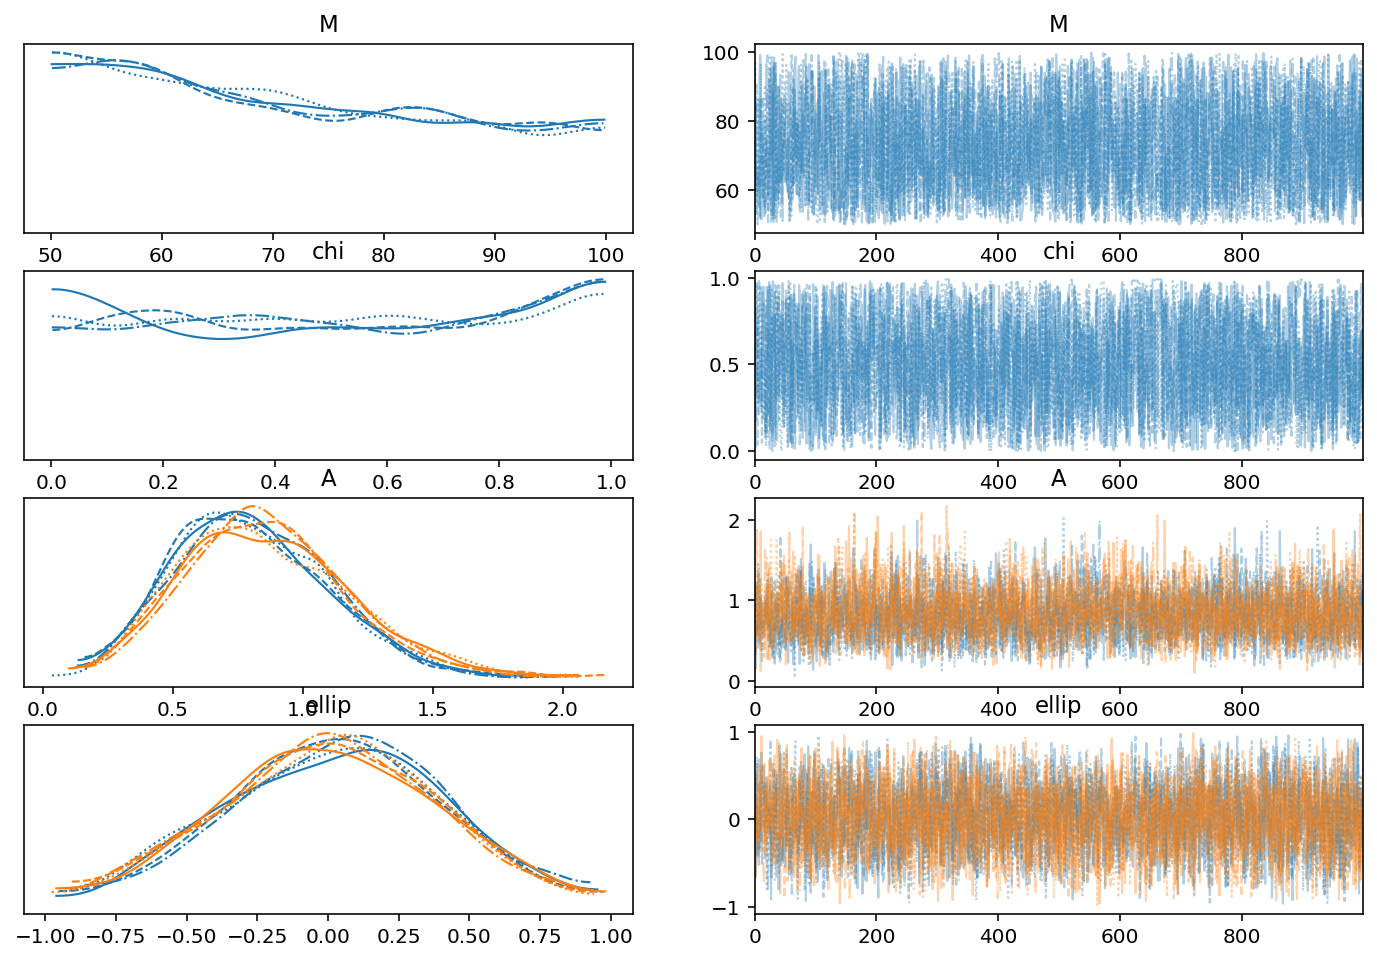

In [59]:
# of course the result is nonsense because there was no signal in the data

import arviz as az
az.plot_trace(f2.result, var_names=['M', 'chi', 'A', 'ellip']);

In [60]:
# we could've also done a prior-only run
f2.run(prior=True)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_1mjebum7/model_gxl4bt3k.stan', line 34, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_1mjebum7/model_gxl4bt3k.stan', line 35, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_1mjebum7/model_gxl4bt3k.stan', line 36, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    wil

Running mchi


Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


In [61]:
# the result is saved in prior
f2.prior

Inference data with groups:
	> posterior
	> sample_stats

/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/wfarr/miniconda3/envs/ringdown/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no 

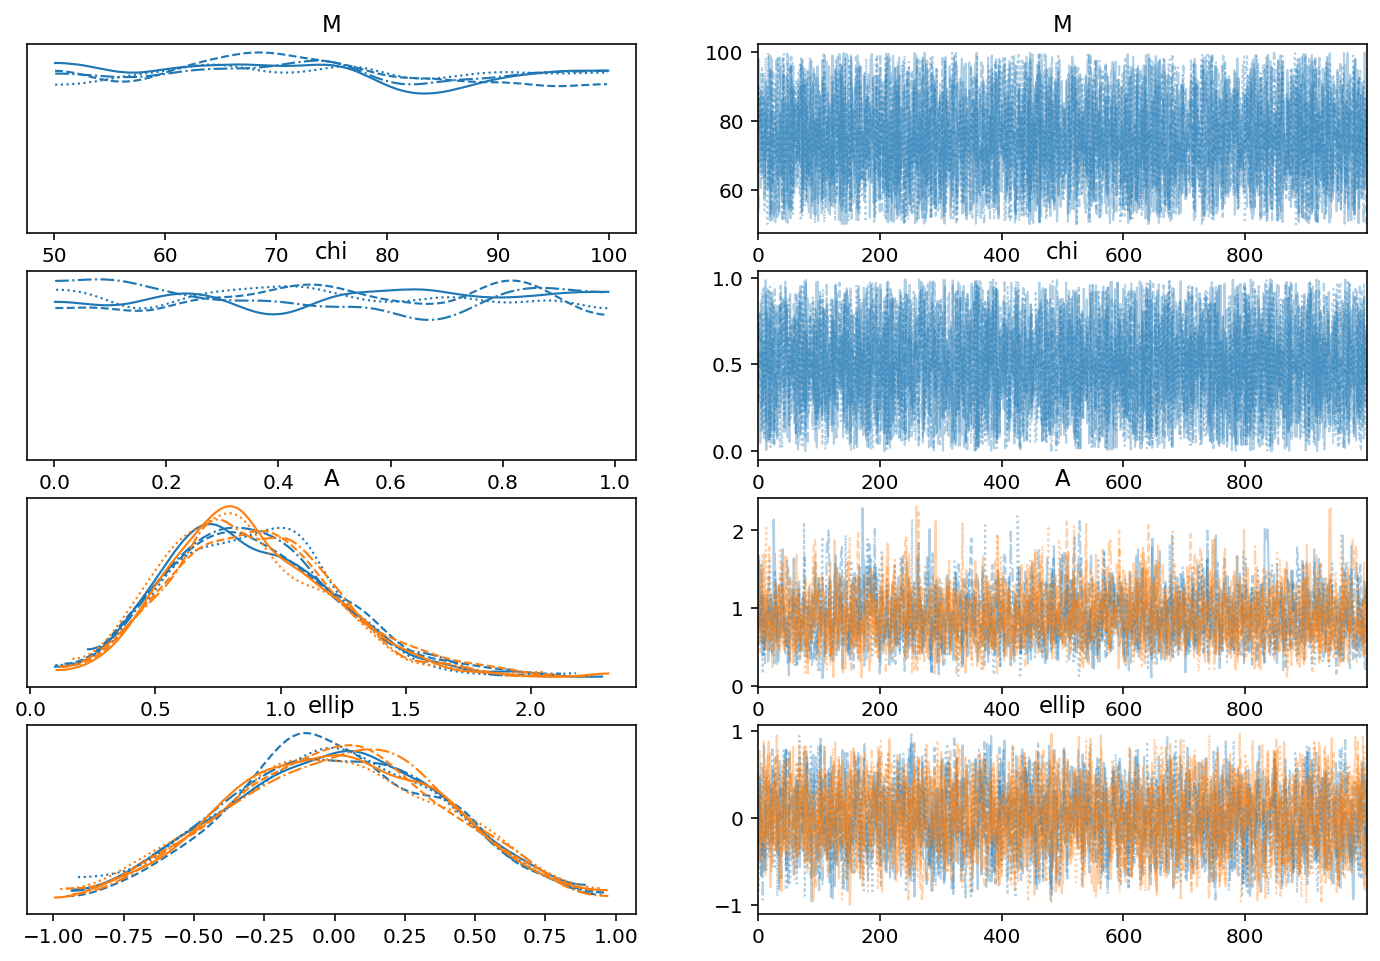

In [62]:
# of course the result is nonsense because there was no signal in the data

import arviz as az
az.plot_trace(f2.prior, var_names=['M', 'chi', 'A', 'ellip', 'drift']);

In [63]:
# we can check what input was passed to stan by calling
# (could've also done this before running / compiling)

# f2.model_input

#### Frequency-damping fits

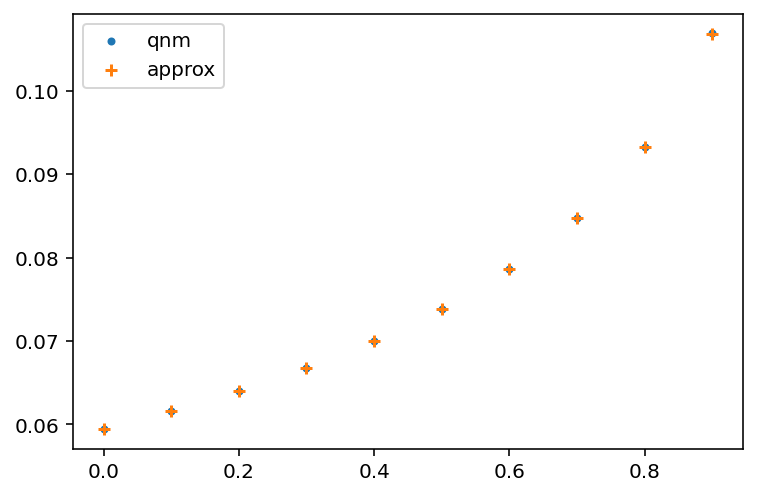

In [64]:
# we can check the approximations used in the Kerr fit
# let's look at the fundamental

mode = ringdown.qnms.KerrMode(f2.modes[0])

chis = linspace(0, 1, 10, endpoint=False)
scatter(chis, mode.ftau(chis)[0], marker='.', label='qnm')
scatter(chis, mode.ftau(chis, approx=True)[0], marker='+', label='approx')
legend();

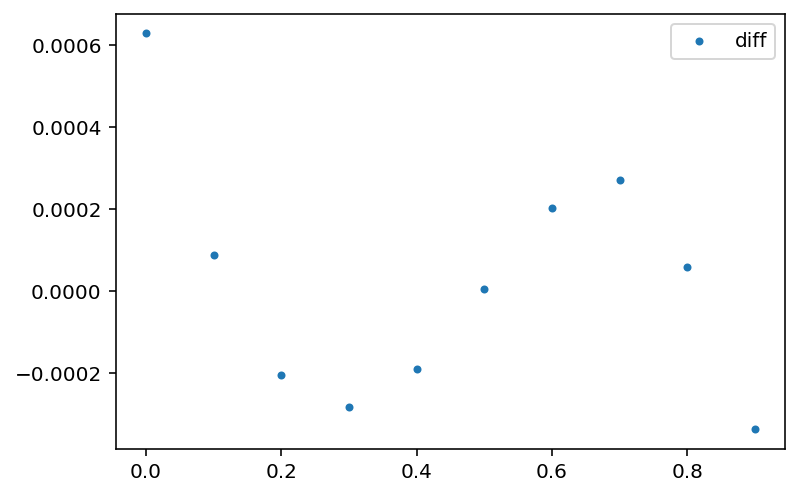

In [65]:
# we can check the approximations used in the Kerr fit
# let's look at the fundamental

mode = ringdown.qnms.KerrMode(f2.modes[0])

chis = linspace(0, 1, 10, endpoint=False)
scatter(chis, (mode.ftau(chis, approx=True)[0] - mode.ftau(chis)[0])/mode.ftau(chis, approx=True)[0], marker='.', label='diff')
legend();